# Fake Job Posting Prediction

import the necessary packages

In [2]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt 
import seaborn as sns

In [3]:
df=pd.read_csv('fake_job_postings.csv')
df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


<h4>Finding the correlation of the attributes in the dataset</h4>

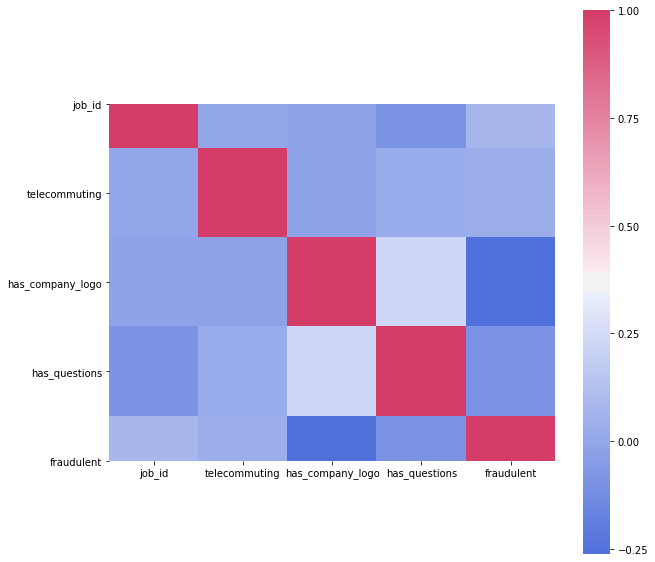

In [4]:
plt.figure(figsize = (10,10))
corr = df.corr()
sns.heatmap(corr , mask=np.zeros_like(corr, dtype=np.bool) , cmap=sns.diverging_palette(-100,0,as_cmap=True) , square = True)

In [5]:
df.fraudulent.value_counts()

0    17014
1      866
Name: fraudulent, dtype: int64

<h4>Representation of the dataset</h4>

(0, 1800)

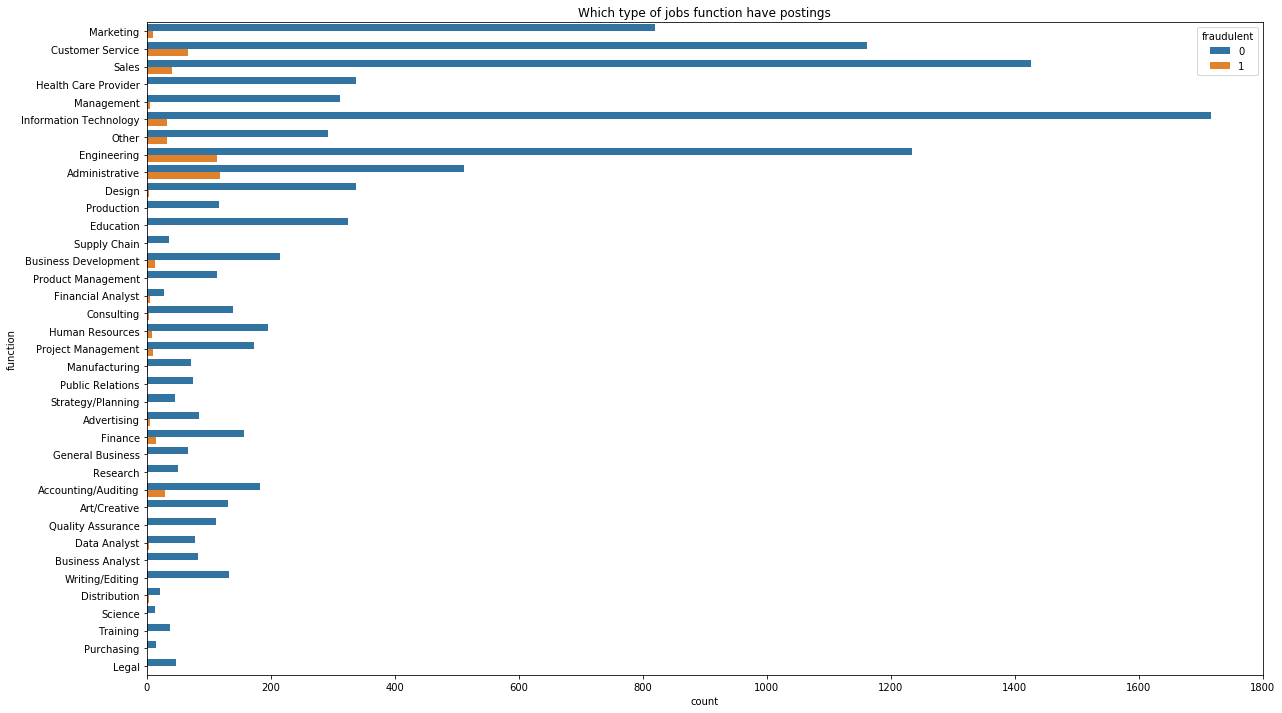

In [6]:
plt.figure(1,figsize=(20,12))
sns.countplot(y=df.function,hue=df.fraudulent);
plt.title('Which type of jobs function have postings');
plt.xlim(0,1800)

<h2>Data Preprocessing</h2>

Seperating the text based attributes and appending the length and word count of the attributes fro text analysis

In [7]:
cols = ["title", "company_profile", "description", "requirements", "benefits"]
for c in cols:
    df[c] = df[c].fillna("")

def extract_features(df):    
    for c in cols:
        df[c+"_len"] = df[c].apply(lambda x : len(str(x)))
        df[c+"_wc"] = df[c].apply(lambda x : len(str(x.split())))

    
extract_features(df)

Using TFID for text analysis

In [8]:
df['combined_text'] = df['company_profile'] + " " + df['description'] + " " + df['requirements'] + " " + df['benefits']

n_features = {
    "title" : 100,
    "combined_text" : 500
}

for c, n in n_features.items():
    tfidf = TfidfVectorizer(max_features=n, norm='l2', stop_words = 'english')
    tfidf.fit(df[c])
    tfidf_train = np.array(tfidf.transform(df[c]).toarray(), dtype=np.float16)

    for i in range(n_features[c]):
        df[c + '_tfidf_' + str(i)] = tfidf_train[:, i]

Creating dummies for attributes

In [9]:
cat_cols = ["employment_type", "required_experience", "required_education", "industry", "function"]
for c in cat_cols:
    encoded = pd.get_dummies(df[c])
    df = pd.concat([df, encoded], axis=1)

Dropping the irrelevant columns from the dataset

In [10]:
drop_cols = ['title', 'location', 'department', 'salary_range', 'company_profile', 'description', 'requirements', 'benefits', 'combined_text']
drop_cols += cat_cols
df = df.drop(drop_cols, axis = 1)
df.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,0,1,0,0,0,0,0
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,0


<h2>Outlier Analysis</h2>

<h4>Using Interquartile range</h4>

In [20]:
x=df.drop(['fraudulent','job_id'],axis=1)
def find_outliers_tukey(x):
    q1=np.percentile(x,25)
    q3=np.percentile(x,75)
    iqr=q3-q1
    floor=q1-1.5*iqr
    ceiling=q3+1.5*iqr
    outlier_indices=list(x.index[(x<floor)|(x>ceiling)])
    outlier_values=list(x[outlier_indices])
    
    return outlier_indices,outlier_values

In [22]:
tukey_indices,tukey_values=find_outliers_tukey(x['company_profile_len'])
print(np.sort(tukey_values[0:5]))

[2270 2289 2480 2676 5574]


<h4>Using Z-score</h4>

In [26]:
outliers=[]
def detect_outliers(x):
    threshold=3
    mean=np.mean(x)
    std=np.std(x)
    for i in x:
        z_score=(i-mean)/std
        if np.abs(z_score)>threshold:
            outliers.append(i)
    return outliers

In [28]:
outlier_pt=detect_outliers(x['company_profile_len'])
print(outlier_pt[0:5])

[2676, 5574, 2480, 2419, 2438]


<h4>Using Kernal Density Estimation</h4>

In [31]:
from statsmodels.nonparametric.kde import KDEUnivariate
from sklearn.preprocessing import scale
def find_outlier_kde(x):
    x_scaled=scale(list(map(float,x)))
    kde=KDEUnivariate(x_scaled)
    kde.fit(bw="scott",fft=True)
    pred=kde.evaluate(x_scaled)
    
    n=sum(pred<0.05)
    outlier_index=np.asarray(pred).argsort()[:n]
    outlier_value=np.asarray(x)[outlier_index]
    
    return outlier_value,outlier_index

In [34]:
kde_value,kde_index=find_outlier_kde(x['company_profile_len'])
print(np.sort(kde_value[0:5]))

[3244 3626 3726 5574 6178]


In [37]:
from sklearn import datasets 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
%matplotlib inline

Text(0, 0.5, 'Probability Density')

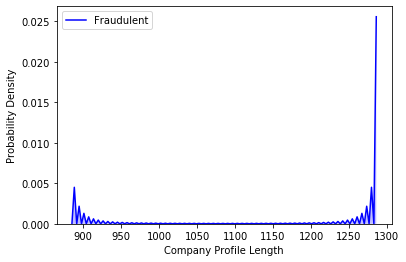

In [41]:
sns.kdeplot(df.loc[(df['fraudulent']), 
            'company_profile_len'], color='b', shade=True, Label='Fraudulent') 
  
# Setting the X and Y Label 
plt.xlabel('Company Profile Length') 
plt.ylabel('Probability Density') 

<h4>Using Boxplot</h4>

{'whiskers': [<matplotlib.lines.Line2D at 0x2a580ba1048>,
 'caps': [<matplotlib.lines.Line2D at 0x2a5814e8288>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a5814d0588>],
 'medians': [<matplotlib.lines.Line2D at 0x2a56c1e9ac8>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a56c2ea908>],
 'means': []}

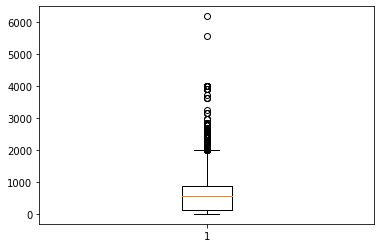

In [35]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline  

plt.boxplot(x['company_profile_len'])

<h2>Classification</h2>

<h4>Using KNN</h4>

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np

In [44]:
y=df.fraudulent
print(y.head())

0    0
1    0
2    0
3    0
4    0
Name: fraudulent, dtype: int64


In [45]:
X=df.drop('fraudulent',1)
print(X.head())

   job_id  telecommuting  has_company_logo  has_questions  title_len  \
0       1              0                 1              0         16   
1       2              0                 1              0         41   
2       3              0                 1              0         39   
3       4              0                 1              0         33   
4       5              0                 1              1         19   

   title_wc  company_profile_len  company_profile_wc  description_len  \
0        23                  885                1309              905   
1        60                 1286                1745             2077   
2        52                  879                1302              355   
3        49                  614                 868             2600   
4        29                 1628                2250             1520   

   description_wc  ...  Public Relations  Purchasing  Quality Assurance  \
0            1278  ...                 0           0 

In [46]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.3, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (12516, 807) (12516,)
Test set: (5364, 807) (5364,)


In [47]:
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

n= mean_acc.argmax()+1

In [48]:
print(n)

2


In [49]:
neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
yhat = neigh.predict(X_test)
accuracy_KNN=metrics.accuracy_score(y_test, yhat)
print("Train set Accuracy: ", metrics.accuracy_score(y_train, neigh.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.9787472035794184
Test set Accuracy:  0.9640193885160329


In [50]:
confusion_matrix_KNN=metrics.confusion_matrix(y_test, yhat, labels=[0,1])

In [51]:
print(confusion_matrix_KNN)

[[5064   31]
 [ 162  107]]


<h4>Using Decision Tree(GINI,Entropy)</h4>

In [52]:
from sklearn.tree import DecisionTreeClassifier

In [53]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
loantree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
loantreeG = DecisionTreeClassifier(criterion="gini", max_depth = 4)
loantree.fit(X_trainset,y_trainset)
loantreeG.fit(X_trainset,y_trainset)
predTree = loantree.predict(X_testset)
predTreeG = loantreeG.predict(X_testset)

In [54]:
accuracy_DT_Entropy=metrics.accuracy_score(y_testset, predTree)
accuracy_DT_GINI=metrics.accuracy_score(y_testset, predTreeG)

In [55]:
print("DecisionTrees's Accuracy with entropy: ",accuracy_DT_Entropy)
print("DecisionTrees's Accuracy with Gini: ", accuracy_DT_GINI)

DecisionTrees's Accuracy with entropy:  0.97110365398956
DecisionTrees's Accuracy with Gini:  0.9739000745712155


In [56]:
confusion_matrix_Entropy=metrics.confusion_matrix(y_test,predTree, labels=[0,1])
confusion_matrix_Gini=metrics.confusion_matrix(y_test, predTreeG, labels=[0,1])

In [57]:
print(confusion_matrix_Entropy)
print(confusion_matrix_Gini)

[[4997   98]
 [ 259   10]]
[[4966  129]
 [ 257   12]]


<h4>Using Logistic Regression</h4>

In [58]:
from sklearn.linear_model import LogisticRegression

In [59]:
X_trainLG, X_testLG, y_trainLG, y_testLG = train_test_split( X, y, test_size=0.2, random_state=4)
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_trainLG,y_trainLG)
yhatLG = LR.predict(X_testLG)
yhat_prob = LR.predict_proba(X_testLG)

In [60]:
confusion_matrix_LG = metrics.confusion_matrix(y_testLG,yhatLG, labels=[0,1])
accuracy_LG=metrics.accuracy_score(y_testLG, yhatLG)
print(metrics.accuracy_score(y_testLG, yhatLG))
print(confusion_matrix_LG)

0.9457494407158836
[[3380    1]
 [ 193    2]]


<h2>Clustering</h2>

<h4>Using KMeans Clustering</h4>

In [26]:
from sklearn.cluster import KMeans 

In [27]:
clusterNum = 2
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 1 1 ... 0 0 0]


In [28]:
df["fraudulent_KMeans"] = labels
df.head(5)

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing,fraudulent_KMeans
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,1
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,1
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,1
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,1,0,0,0,0,0,1
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,1


In [29]:
df.groupby('fraudulent_KMeans').mean()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
fraudulent_KMeans,,,,,,,,,,,,,,,,,,,,,
0,13409.999776,0.040040,0.807851,0.436640,0.049994,28.862767,41.243932,634.031205,918.634269,1213.171905,...,0.004026,0.001230,0.005816,0.003803,0.079186,0.001118,0.002237,0.002349,0.002349,0.008053
1,4470.000224,0.045755,0.782750,0.546817,0.046873,28.197785,40.106611,607.768766,878.805907,1222.838013,...,0.004475,0.000447,0.006600,0.001790,0.085021,0.000447,0.002909,0.001678,0.001902,0.006712


<h4>Using Dbscan</h4>

In [30]:
from sklearn.cluster import DBSCAN 

In [31]:
df=df.drop('fraudulent_KMeans',1)

In [32]:
db = DBSCAN(eps=0.15, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
df["fraudulent_DBSCAN"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
df.head(5)

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing,fraudulent_DBSCAN
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,-1
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,-1
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,-1
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,1,0,0,0,0,0,-1
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,-1


In [33]:
set(labels)

{-1}

In [34]:
df=df.drop('fraudulent_DBSCAN',1)

In [35]:
x=df.values
x[0:5]

array([[1., 0., 1., ..., 0., 0., 0.],
       [2., 0., 1., ..., 0., 0., 0.],
       [3., 0., 1., ..., 0., 0., 0.],
       [4., 0., 1., ..., 0., 0., 0.],
       [5., 0., 1., ..., 0., 0., 0.]])

<h4>Using Hierarchial Clustering</h4>

In [36]:
from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from matplotlib import pyplot as plt 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering 

In [38]:
agglom = AgglomerativeClustering(n_clusters = 2, linkage = 'complete')
agglom.fit(X)
agglabels=agglom.labels_
print(agglabels)

[0 0 0 ... 0 0 0]


In [47]:
df['cluster_Hierarchy'] = agglabels
df.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing,cluster_Hierarchy
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,1,0,0,0,0,0,0
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df=df.drop('cluster_Hierarchy',1)


In [49]:
df.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Public Relations,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,0
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,0,1,0,0,0,0,0
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,0


<h4>Using hdbscan</h4>

In [50]:
import hdbscan

In [51]:
clusterer = hdbscan.HDBSCAN(metric='manhattan')
clusterer.fit(X)
hdblabels=clusterer.labels_
hprint(hdblabels)

[-1 -1 -1 ... -1 -1 -1]


In [52]:
df['fraudulent_HDBScan'] = hdblabels
df.head()

,job_id,telecommuting,has_company_logo,has_questions,fraudulent,title_len,title_wc,company_profile_len,company_profile_wc,description_len,...,Purchasing,Quality Assurance,Research,Sales,Science,Strategy/Planning,Supply Chain,Training,Writing/Editing,fraudulent_HDBScan
0,1,0,1,0,0,16,23,885,1309,905,...,0,0,0,0,0,0,0,0,0,-1
1,2,0,1,0,0,41,60,1286,1745,2077,...,0,0,0,0,0,0,0,0,0,-1
2,3,0,1,0,0,39,52,879,1302,355,...,0,0,0,0,0,0,0,0,0,-1
3,4,0,1,0,0,33,49,614,868,2600,...,0,0,0,1,0,0,0,0,0,36
4,5,0,1,1,0,19,29,1628,2250,1520,...,0,0,0,0,0,0,0,0,0,-1


<h2>Comparing the accuracy</h2>

In [66]:
import matplotlib.pyplot as plt

In [71]:
dic={'KNN':(accuracy_KNN*100),'Decision Tree Entropy':(accuracy_DT_Entropy*100),'Decision Tree GINI':(accuracy_DT_GINI*100),
     'Logistic Regression':(accuracy_LG*100)}
dic

{'KNN': 96.40193885160329,
 'Decision Tree Entropy': 97.110365398956,
 'Decision Tree GINI': 97.39000745712156,
 'Logistic Regression': 94.57494407158836}

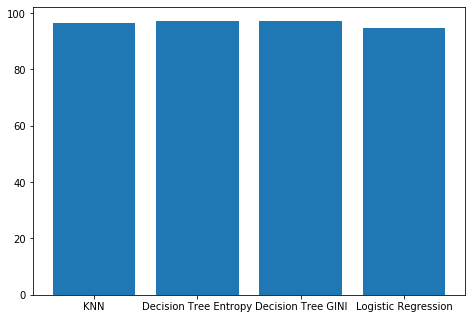

In [72]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(dic.keys(),dic.values())
plt.show()

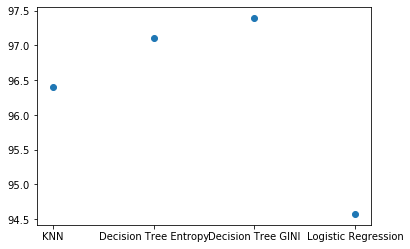

In [73]:
plt.scatter(dic.keys(),dic.values()) 
plt.show()

<h4>As seen by the scatter plot above the implementation of Decision Tree under GINI provides the best results</h4>